# Introduction to Options and Option pricing using "quantsbin" library

## PART 2

In this part of the tutorial we will explore below topics:
    1. Equity Option valuation.
        i. European and American Option.
        ii. Dividend - yield and discrete amount
    2. FX Option valuation.
        i. Local and Foriegn interest rate.
    3. Commodity options.
        i. Cost and Convinience yields.
    4. Options on Futures.
    5. Calculating Numerical greeks
    6. PnL attribution calculation



Import **Quantsbin** the Derivative pricing module and assign qbdp as alias to it.

In [1]:
import quantsbin.derivativepricing as qbdp

### Defining Option Objects

As discussed in Part 1 of tutorial, in current release **Quantsbin** provide options to define under four asset classes.
Options on:
    1. Equity: qbdp.EqOption
    2. Futures: qbdp.FutOption
    3. Currencies: qbdp.FXOption
    4. Commodities: qbdp.ComOption
    
 Let's check doc string to get more information about Option objects.

In [2]:
print(qbdp.EqOption.__doc__)


    Defines object for vanilla options on equity with both European and American expiry type.

    Args required:
            option_type: 'Call' or 'Put' (default value is set to 'Call')
            expiry_type: 'European' or 'American' (default is set to 'European')
            strike: (Float in same unit as underlying price) e.g. 110.0
            expiry_date: (Date in string format "YYYYMMDD") e.g. 10 Dec 2018 as "20181210"
            derivative_type: Default value as "Vanilla Option".
    


Starting with Equity Options:

### 1. Equity Option Valuation 

Defining Equity Put options with 'European' and 'American' expiry

In [3]:
equity_p1 = qbdp.EqOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='European')
equity_p2 = qbdp.EqOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='American')

**Payoff calculation:**

In [4]:
print("equity_p1 payoff for Spot at 45 is {}".format(equity_p1.payoff(45)))
print("equity_p2 payoff for Spot at 45 is {}".format(equity_p2.payoff(45)))

equity_p1 payoff for Spot at 45 is 5
equity_p2 payoff for Spot at 45 is 5


**Models available**

Let's check what all models are available for valuation of two options.

In [5]:
print("Models available for equity_p1 are {}".format(equity_p1.list_models()))
print("Models available for equity_p2 are {}".format(equity_p2.list_models()))

Models available for equity_p1 are BSM, MC_GBM, Binomial
Models available for equity_p2 are MC_GBM, Binomial


We can observe we don't have BlackScholesMerton(BSM) model available for American expiry option.
Note* For American Option MonteCarlo model used is LongStaff Schwartz model.


**Defining Engine**

Start with checking doc string for Equity option engine method. It provides complete list of parameters which could be passed to engine method

In [6]:
print(equity_p1.engine.__doc__)


        Binds pricing model class and market data to the object
            Args required:
                Core Arguments:
                    model: pricing model (default value set to BSM for European expiry)
                           To check available list of models use print(option_object.list_models())
                    fwd0: (float) current underlying price/value e.g. 110.0
                    rf_rate: (Float < 1) risk free continuously compounded discount rate e.g. 5% as 0.05
                    volatility: (Float < 1) Underlying price/value return annualized volatility.
                                Volatility in decimal e.g. Volatility of 10% => 0.10
                    pricing_Date: Date on which option value need to be calculated.
                                  (Date in string format "YYYYMMDD") e.g. 10 Dec 2018 as "20181210".
                    yield_div: (Float < 1) div yield continuously compounded (for index options) e.g. 5% as 0.05
                    div_lis

Two interesting parameters here are 
1. yield_div - Continuously compunded dividend yield for Options on index
2. div_list - To give discrete dividend list as input for Option on single stocks or ETFs

We will start by looking at Options on index and pass market as well as Model paramters to above defined options.
We will be using BSM model for European Option and Binomial for American Option.

** Options on Index **

In [7]:
market1_parameters = {'spot0': 45
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate':.05
                     , 'yield_div':0.02}

eq1_BSM_market1 = equity_p1.engine(model="BSM", **market1_parameters)
eq1_market1 = equity_p1.engine(model="Binomial", **market1_parameters)
eq2_market1 = equity_p2.engine(model="Binomial", **market1_parameters)

Start with comparing valuations.

In [8]:
print("Value of eq1 under market 1 with BSM model is {}".format(eq1_BSM_market1.valuation()))
print("Value of eq1 under market 1 with Binomial model is {}".format(eq1_market1.valuation()))
print("Value of eq2 under market 1 with Binomial model is {}".format(eq2_market1.valuation()))

Value of eq1 under market 1 with BSM model is 6.939586499057242
Value of eq1 under market 1 with Binomial model is 6.946369519179399
Value of eq2 under market 1 with Binomial model is 7.444393326701226


As expected valuation of American Option is greater than European Option when we use Binomial method for both the options where as value of European option as calculated using BSM and Binomial is close.

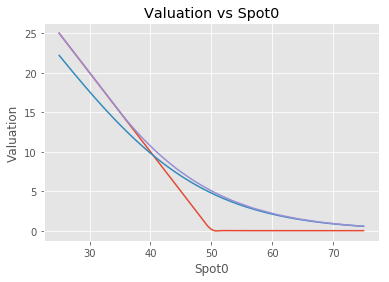

In [9]:
eq1_payoff = qbdp.Plotting(equity_p1, 'payoff', x_axis_range=[25,75]).line_plot()
eq1_val = qbdp.Plotting(eq1_BSM_market1, 'valuation', x_axis_range=[25,75]).line_plot()
eq2_val = qbdp.Plotting(eq2_market1, 'valuation', x_axis_range=[25,75]).line_plot()
eq2_val.show()

Blue line is for European Put, Purple line is for American Put, and Red line is for Payoff

Now we will see how to add Discrete known dividend to market parameters.

**Discrete Dividend**

Add discrete dividend to market parameter using div_list parameter and price option using MC_GBM

In [10]:
market2_parameters = {'spot0': 46
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate':.05
                     , 'div_list':[("20180610", 2), ("20181224", 4)]}

eq1_market2 = equity_p1.engine(model="MC_GBM", **market2_parameters, no_of_path=100000, antithetic=True, seed=420)
print("Value of eq1 under market 1 with MC is {}".format(eq1_market2.valuation()))

Value of eq1 under market 1 with MC is 9.233941316501841


### FX Options

We will quickly cover an example of FX option wherein risk free rate and dividend yield are replaced by risk free rate for local currency and risk free rate for foriegn currency.

Let's start with defining an option and printing list of models available.

In [11]:
fx_p1 = qbdp.FXOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='European')
print("Models available for fx_p1 are {}".format(fx_p1.list_models()))

Models available for fx_p1 are GK, MC_GBM, Binomial


GK(Garman–Kohlhagen) model uses BlackScholes framework to price FX options. Lets price FX option.

In [12]:
market1_parameters = {'spot0': 45
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate_local':.05
                     , 'rf_rate_foreign':.02}

fx1_market1 = fx_p1.engine(model="GK", **market1_parameters)
print("Value of fx1 under market 1 with GK model is {}".format(fx1_market1.valuation()))

Value of fx1 under market 1 with GK model is 6.939586499057242


### Commodities Options

Commodities options could also be prices using Quantsbin similar to FX options.
In commodities options we have option to add continuously compounded cost yield and convinience yield.

In [13]:
com_p1 = qbdp.ComOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='European')
print("Models available for com_p1 are {}".format(fx_p1.list_models()))

Models available for com_p1 are GK, MC_GBM, Binomial


In [14]:
market1_parameters = {'spot0': 45
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate':.05
                     , 'cnv_yield':0.02
                     , 'cost_yield':0.03}

com1_market1 = com_p1.engine(model="GK", **market1_parameters)
print("Value of com_p1 under market 1 with GK model is {}".format(com1_market1.valuation()))

Value of com_p1 under market 1 with GK model is 5.960472559488654


### Futures Options

In similar lines we can define options on futures.

In [15]:
fut_p1 = qbdp.FutOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='European')
print("Models available for com_p1 are {}".format(fut_p1.list_models()))

Models available for com_p1 are B76, MC_GBM, Binomial


In case of options on futures we have Black 76 form BlackScholes framework along with Monte Carlo stimulation and Binomial method.

In [16]:
market1_parameters = {'fwd0': 45
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate':.05
                     }
fut1_market1 = fut_p1.engine(model="B76", **market1_parameters)
print("Value of com_p1 under market 1 with B76 model is {}".format(fut1_market1.valuation()))

Value of com_p1 under market 1 with B76 model is 7.987642268808962


With this we have seen how to define options and valuate them in different asset classes.
In next section we will see other important functionalities provided Quantsbin:
1. Numerical Greek Calculation: Greek calculations by method of full valuation.
2. PnL attribution

### Numerical Greeks

We will calculate numerical greeks for Equity Option.
In Numerical greek calculation, Quantsbin provide us with option to define percentage by which we want to bump each parameter.

In [17]:
equity_p1 = qbdp.EqOption(option_type='Put', strike=50, expiry_date='20190721', expiry_type='European')
market1_parameters = {'spot0': 45
                     , 'pricing_date':'20180121'
                     , 'volatility':.25
                     , 'rf_rate':.05
                     , 'yield_div':0.02}

eq1_BSM_market1 = equity_p1.engine(model="BSM", **market1_parameters)
print("----Numerical Risk Parameters----")
print(eq1_BSM_market1.risk_parameters_num(delta_spot=.03, delta_time=2, delta_rf_rate=.03, delta_vol=.1))
print("----Analytical Risk Parameters----")
print(eq1_BSM_market1.risk_parameters())

----Numerical Risk Parameters----
{'delta': -0.50281326794859904, 'gamma': 0.028091779031930969, 'theta': -0.0020678880876818795, 'vega': 21.283276393791652, 'rho': -44.217003870260875}
----Analytical Risk Parameters----
{'delta': 0.51791732590176853, 'gamma': 0.02811099474422615, 'theta': -0.0020639439442300834, 'vega': 21.288302286954551, 'rho': -44.2169058106834, 'phi': 34.863640266866994}


### PnL Attribution

PnL attribution allows us to attribute change in option price to each of the underlying parameter.
We start by defining option and then call PnL Attribution method along with movement in market paramters in percentage terms.

In [18]:
eq1_BSM_market1.pnl_attribution(delta_spot=.03, delta_time=2, delta_rf_rate=.03, delta_vol=.1)

{'spot0': -0.65319927808776157,
 '_pricing_date': -0.004135776175363759,
 'volatility': 0.53251153820120578,
 'rf_rate': -0.066107792410942778,
 'cnv_yield': 0,
 'cost_yield': 0}